In [1]:
%%capture 
!pip install rectools optuna shap catboost

In [2]:
import os

import pandas as pd
import numpy as np

import requests
from tqdm.auto import tqdm
from zipfile import ZipFile

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from rectools.metrics import calc_metrics, NDCG, MAP, Precision, Recall, MeanInvUserFreq
from rectools.models.popular import PopularModel
from rectools import Columns
from rectools.dataset import Dataset

from lightgbm import LGBMRanker
from xgboost import XGBRanker
from catboost import CatBoostRanker, Pool

import optuna
import dill

from typing import Callable, Dict, Set, List, Optional, Any, Tuple

import gc
from timeit import Timer

import shap
from pprint import pprint
     
import warnings
warnings.filterwarnings('ignore')

In [3]:
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
     
SEED = 2022
K_RECOS = 10
TOP_N = 30

# TOOLS

In [4]:
def avg_user_metric(
        y_true: np.ndarray,
        y_pred: np.ndarray,
        user_ids: np.ndarray,
        metric_function: Callable[[np.ndarray, np.ndarray], float],
) -> float:
    """
    Вычисляем метрику, усредненную по всем значимым (есть разные таргеты) группам.
    :param y_true: список таргетов
    :param y_pred: список предсказаний
    :param user_ids: список групп (обычно это список user_id той же размерности, что и предсказания и таргеты)
    :param metric_function: усредняемая метрика(y_true, y_pred) -> float
    :return: значение метрики metric_function, усредненное по всем значимым группам
    """
    avg_score: float = 0.

    if len(y_pred) == len(y_true) == len(user_ids):
        l_ind: int = 0
        cur_group_id: int = user_ids[0] if len(user_ids) else 0
        n_groups: int = 0
        for r_ind, group_id in enumerate(user_ids):
            if group_id != cur_group_id or r_ind == len(user_ids) - 1:
                if r_ind == len(user_ids) - 1:
                    r_ind += 1
                group_true = y_true[l_ind: r_ind]
                if not np.all(group_true == group_true[0]):
                    avg_score += metric_function(group_true, y_pred[l_ind: r_ind])
                    n_groups += 1
                l_ind = r_ind
                cur_group_id = group_id
        avg_score /= max(1, n_groups)
    else:
        raise ValueError(f'Размерности не совпадают: '
                         f'y_pred - {len(y_pred)}, y_true - {len(y_true)}, user_ids - {len(user_ids)}')
    return avg_score

In [5]:
def calc_metrics_(candidates_df, rank_col: str) -> Dict[str, float]:
    metrics = {
        'ndcg@10': NDCG(k=10),
        'map@10': MAP(k=10),
        'Precision@10': Precision(k=10),
        'recall@10': Recall(k=10),
        'novelty@10': MeanInvUserFreq(k=10),
    }
    return calc_metrics(
        metrics=metrics,
        reco=(
            candidates_df
            .rename(columns={rank_col: Columns.Rank})
            [[Columns.User, Columns.Item, Columns.Rank]]
            [candidates_df[Columns.User].isin(test_users)]
        ),
        interactions=(
            ranker_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [ranker_data[Columns.User].isin(test_users)]
        ), 
        prev_interactions=(
            base_models_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [base_models_data[Columns.User].isin(test_users)]
        ),
        catalog=items['item_id'].unique()
    )

# KION DATASET

In [6]:
url = 'https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip'

req = requests.get(url, stream=True)

PATH_TO_DATA = 'kion_train.zip'

with open(PATH_TO_DATA, 'wb') as f:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        f.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [7]:
with ZipFile(PATH_TO_DATA) as z:
    
    with z.open('kion_train/interactions.csv') as f:
        interactions = pd.read_csv(f)
    
    with z.open('kion_train/items.csv') as f:
        items = pd.read_csv(f)
        
    with z.open('kion_train/users.csv') as f:
        users = pd.read_csv(f)

## Interactions

In [8]:
# Меняем названия колонок для использования rectools
interactions.rename(
    columns={
        'last_watch_dt': Columns.Datetime,
        'watched_pct': Columns.Weight,
    }, 
    inplace=True,
) 
# Меняем тип данных
interactions['datetime'] = interactions['datetime'].astype(np.datetime64)

# Заполняем пропуски
interactions_default_values: Dict[str, Any] = {
   Columns.Datetime: interactions[Columns.Datetime].median(),
    Columns.Weight: 0.,
    'total_dur': 0,
}
interactions.fillna(interactions_default_values, inplace=True)

# Смотрим что получилось
interactions.head(5)

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


## Users

In [9]:
def encode_cat_cols(df: pd.DataFrame, cat_cols) -> Tuple[pd.DataFrame, Dict]:
    cat_col_encoding = {}  # словарь с категориями

    # Тут мы могли бы заполнять пропуски как еще одну категорию,
    # но они и так заполняются таким образом автоматически ниже
    # default_values = {col: 'None' for col in cat_cols}
    # df.fillna(default_values, inplace=True)

    for col in cat_cols:
        cat_col = df[col].astype('category').cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype('category')
    return df, cat_col_encoding

users_cat_cols = [
    # 'user_id',
     'age', 'income', 'sex', 'kids_flg'
]

users, users_cat_col_encoding = encode_cat_cols(users, users_cat_cols)
users.head(5)

,user_id,age,income,sex,kids_flg
0,973171,1,4,1,1
1,962099,0,2,1,0
2,1047345,3,3,0,0
3,721985,3,2,0,0
4,704055,2,4,0,0


## Items

In [10]:
# Аналогичным образом кодируем категориальные колонки и пока удаляем текстовые
items_cat_cols = [
    # 'item_id', 
    'content_type', 'for_kids', 'studios',
]
items_text_cols = [
    'title', 'title_orig', 'genres', 'countries', 'directors', 'actors', 'description', 'keywords',
]
items_num_cols = [
    'release_year', 'age_rating', 
]
default_values_items = {
    'release_year': items['release_year'].median(),
    'age_rating': items['age_rating'].median(),
}

items, items_cat_col_encoding = encode_cat_cols(items, items_cat_cols) 
items = items.drop(items_text_cols, axis=1)
items.fillna(default_values_items, inplace=True)

items.head(5)

,item_id,content_type,release_year,for_kids,age_rating,studios
0,10711,0,2002.0,-1,16.0,-1
1,2508,0,2014.0,-1,16.0,-1
2,10716,0,2011.0,-1,16.0,-1
3,7868,0,2015.0,-1,16.0,-1
4,16268,0,1978.0,-1,12.0,33


# Train/val/test split

In [11]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

print(f'min дата в interactions: {min_date}')
print(f'max дата в interactions: {max_date}')
print(f'Продолжительность: {max_date - min_date}')

min дата в interactions: 2021-03-13 00:00:00
max дата в interactions: 2021-08-22 00:00:00
Продолжительность: 162 days 00:00:00


In [12]:
# Обучать ранжирование будем на последнем месяце (30 дней) не считая отложенной недели
# Лучше зафиксировать временной диапазон если на проде планируется переобучать модель
ranker_days_count = 30

ranker_data = interactions[
    (interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=ranker_days_count))
]

# В дальнейшем ranker_data разбиваем по юзерам 
#  на train val test для обучения, валидации и тестирования ранкера
train_size = 0.7
val_size = 0.15
test_size = 0.15

# В train_test_split очень удобно можно сохранить исходное распределение по нужным факторам,
#  задав параметр stratify. Но не будем использовать сейчас.

train_val_users, test_users = train_test_split(
    ranker_data['user_id'].unique(), random_state=SEED, test_size=test_size
)

train_users, val_users = train_test_split(
    train_val_users, random_state=SEED, test_size=val_size / (train_size + val_size)  # 15% от общего размера
)

base_models_data = interactions[
    (interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count))
]

# Create ranker dataset

generate features for ranker

In [13]:
# Получаем длину истории юзера 
base_models_data['user_hist'] = (
    base_models_data.groupby('user_id')
    ['item_id'].transform('count')
)

# Получаем популярность контента
base_models_data['item_pop'] = (
    base_models_data.groupby('item_id')
    ['user_id'].transform('count')
)

# Получаем среднюю популярность контента, просматриваемого этим юзером
base_models_data['user_avg_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('mean')
)

# Получаем среднюю длину истории пользователя, которые смотрит этот контент
base_models_data['item_avg_hist'] = (
    base_models_data.groupby('item_id')
    ['user_hist'].transform('mean')
)

# Получаем популярность последнего просмотренного контента
base_models_data.sort_values(
    by=[Columns.User, Columns.Datetime], 
    ascending=[True, False], 
    ignore_index=True,
    inplace=True,
)

base_models_data['user_last_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('first')
)
base_models_data.head(3)

,user_id,item_id,datetime,total_dur,weight,user_hist,item_pop,user_avg_pop,item_avg_hist,user_last_pop
0,0,6006,2021-07-20,1,0.0,6,5208,41885.0,16.891897,5208
1,0,7102,2021-07-19,169,3.0,6,11626,41885.0,20.349475,5208
2,0,14359,2021-07-19,130,2.0,6,6053,41885.0,22.546836,5208


In [14]:
# Добавляем новые фичи в соответствующие таблички
items = pd.merge(
    left=items, 
    right=(
        base_models_data
        [['item_id', 'item_pop', 'item_avg_hist']]
        .drop_duplicates()
    ),
    how='left',
    on='item_id',
)

users = pd.merge(
    left=users, 
    right=(
        base_models_data
        [['user_id', 'user_hist', 'user_avg_pop', 'user_last_pop']]
        .drop_duplicates()
    ),
    how='left',
    on='user_id',
)
users.head(3)

,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop
0,973171,1,4,1,1,5.0,19550.800000,93403.0
1,962099,0,2,1,0,13.0,1329.307692,260.0
2,1047345,3,3,0,0,NaN,NaN,NaN


In [15]:
# Обновляем дефолтные значения
# Прямо сейчас обновлять таблички users и items не обязательно, 
# сделаем это при джойне с кандидатами

# Для новых фичей айтемов
default_values_items['item_pop'] = base_models_data['item_pop'].median()
default_values_items['item_avg_hist'] = base_models_data['item_avg_hist'].median()

# Для новых фичей юзеров
default_values_users = {
    'user_hist': 0,
    'user_avg_pop': base_models_data['user_avg_pop'].median(),
    'user_last_pop': base_models_data['user_last_pop'].median(),
}

# Build ranker dataset


In [16]:
def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame, 
    df: pd.DataFrame,
    how='right'
) -> pd.DataFrame:
    df = pd.merge(
        df[df['user_id'].isin(user_list)], 
        candidates_df[candidates_df['user_id'].isin(user_list)], 
        how=how,  # or right?
        on=['user_id', 'item_id']
    )
    
    default_values = {
        'als_score': df['als_score'].min() - 0.01,
        'als_rank': df['als_rank'].max() + 1,
        'lfm_score': df['lfm_score'].min() - 0.01,
        'lfm_rank': df['lfm_rank'].max() + 1,
        'pop_score': df['pop_score'].min() - 0.01,
        'pop_rank': df['pop_rank'].max() + 1,
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)
        
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    return df

In [17]:
# Добавляем фичи
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(
        df, 
        users, 
        how='left', 
        on=['user_id']
    )
    df = pd.merge(
        df, 
        items, 
        how='left', 
        on=['item_id']
    )

    # При джойне могут получиться строки с несуществующими айтемами или юзерами.
    # Надо заполнить пропуски. Используем заготовленные дефолтные значения,
    # чтобы не сделать утечку
    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)

    # Категориальные фичи закодированы пандасом так, что None === -1
    # Если изначально пропусков не было, то нужно добавить такое значение категории
    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)
    return df


In [18]:
candidates_df = pd.read_csv('/kaggle/input/candidates-dataset/als_candidates.csv').rename(
    columns={'rank': 'als_rank', 'score': 'als_score'}
).merge(
    pd.read_csv('/kaggle/input/candidates-dataset/lfm_candidates.csv').rename(
      columns={'rank': 'lfm_rank', 'score': 'lfm_score'}
    ),
    on=['user_id', 'item_id'],
     how='outer'
)
candidates_df = candidates_df[candidates_df['lfm_rank'] < (TOP_N + 1)]

top_popular = pd.read_csv('/kaggle/input/candidates-dataset/popular_candidates.csv').rename(columns={'rank': 'pop_rank', 'score': 'pop_score'}).drop('user_id', axis=1)
candidates_df = candidates_df.merge(top_popular, on='item_id', how='left')

candidates_df.head()

,user_id,item_id,als_score,als_rank,lfm_score,lfm_rank,pop_score,pop_rank
0,176549,13865,0.444931,1.0,-0.000163,1.0,93403.0,3
1,176549,10440,0.420671,2.0,-0.000165,3.0,141889.0,1
2,176549,15297,0.392164,3.0,-0.000164,2.0,137128.0,2
3,176549,4151,0.276921,4.0,-0.000168,4.0,69641.0,5
4,176549,7571,0.255112,5.0,-0.000170,13.0,20407.0,16


In [19]:
ranker_train = users_filter(train_users, candidates_df, ranker_data)
ranker_val = users_filter(val_users, candidates_df, ranker_data)
ranker_test = users_filter(test_users, candidates_df, ranker_data)

ranker_train.head()

,user_id,item_id,datetime,total_dur,weight,als_score,als_rank,lfm_score,lfm_rank,pop_score,pop_rank
2116560,3,142,2021-08-13,5892.0,100.0,0.135519,6.0,0.000007,9.0,35862.0,9
3859724,3,415,2021-07-01,0.0,0.0,-0.006394,31.0,0.000004,28.0,167.0,2664
3859723,3,1819,2021-07-01,0.0,0.0,-0.006394,31.0,0.000004,27.0,9792.0,34
2116566,3,1844,2021-07-01,0.0,0.0,0.047008,12.0,0.000005,18.0,22344.0,15
3859725,3,2358,2021-07-01,0.0,0.0,-0.006394,31.0,0.000004,29.0,4131.0,106


In [20]:
ranker_train = add_features(ranker_train)
ranker_val = add_features(ranker_val)
ranker_test = add_features(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,als_score,als_rank,lfm_score,lfm_rank,pop_score,...,user_hist,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist
0,3,142,2021-08-13,5892.0,100.0,0.135519,6.0,0.000007,9.0,35862.0,...,0.0,11957.864865,2858.0,0,2020.0,-1,16.0,-1,35862.0,15.251464
1,3,415,2021-07-01,0.0,0.0,-0.006394,31.0,0.000004,28.0,167.0,...,0.0,11957.864865,2858.0,1,1983.0,-1,6.0,-1,167.0,27.682635
2,3,1819,2021-07-01,0.0,0.0,-0.006394,31.0,0.000004,27.0,9792.0,...,0.0,11957.864865,2858.0,0,2020.0,-1,16.0,-1,9792.0,14.719669


# Fit rankers

In [21]:
del candidates_df
gc.collect()

23

## Utils

In [22]:
def add_simple_target(df: pd.DataFrame) -> pd.DataFrame:
    df['target'] = df[Columns.Weight] > 50  # 'watched_pct'
    df['target'] = df['target'].astype(int)
    return df

In [23]:
def add_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    0 - доля досмотра < 0.15
    1 - 0.15 <= доля досмотра < 0.75
    2 - 0.75 <= доля досмотра
    """
    df['target_ranker'] = (df[Columns.Weight] >= 15).astype(int)
    df['target_ranker'] += (df[Columns.Weight] >= 75).astype(int)
    return df

In [25]:
def add_score_and_rank(df: pd.DataFrame, y_pred_scores: np.ndarray, name: str) -> pd.DataFrame:
    # Добавляем скор модели второго уровня
    df[f'{name}_score'] = y_pred_scores
    # Добавляем ранг модели второго уровня
    df = df.drop_duplicates(['user_id', 'item_id'], keep='last')
    df.sort_values(
        by=['user_id', f'{name}_score'],
        ascending=[True, False],
        inplace=True,
    )
    df[f'{name}_rank'] = df.groupby('user_id').cumcount() + 1

    # Исключаем айтемы, которые не были предсказаны на первом уровне
    mask = ((df['lfm_rank'] < (TOP_N + 1)) & (df['als_rank'] < (TOP_N + 1)) & df['pop_rank'] < (TOP_N + 1)).to_numpy()

    eps: float = 0.001
    min_score: float = min(y_pred_scores) - eps
    df[f'{name}_hybrid_score'] = df[f'{name}_score'] * mask
    df[f'{name}_hybrid_score'].replace(
        0,
        min_score,
        inplace=True,
    )

    # Добавляем общий ранг двух-этапной модели
    df[f'{name}_hybrid_rank'] = df[f'{name}_rank'] * mask
    max_rank: int = (TOP_N + 1)
    df[f'{name}_hybrid_rank'].replace(
        0,
        max_rank,
        inplace=True,
    )
    return df

In [26]:
ranker_train = add_simple_target(ranker_train)
ranker_val = add_simple_target(ranker_val)
ranker_test = add_simple_target(ranker_test)

In [27]:
ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

In [28]:
# Убираем ненужные айдишники, временные метки и таргеты.
# Для обучения используются только cols:
cols = [
    'als_score', 'als_rank', 'lfm_score', 'lfm_rank', 'pop_score', 'pop_rank',
    'age', 'income', 'sex', 'kids_flg', 'user_hist', 'user_avg_pop', 'user_last_pop',
    'content_type', 'release_year', 'for_kids', 'age_rating', 'studios', 'item_pop', 'item_avg_hist',
]
# Из них категориальные:
cat_cols = [
    'age', 'income', 'sex', 'kids_flg',
    'content_type', 'for_kids', 'studios',
]

In [29]:
for col in ['kids_flg', 'sex', 'content_type', 'for_kids', 'studios']:
    ranker_train[col] = ranker_train[col].astype(int)
    ranker_val[col] = ranker_val[col].astype(int)
    ranker_test[col] = ranker_test[col].astype(int)

## LGBMRanker

In [31]:
# https://lightgbm.readthedocs.io/en/v3.3.2/pythonapi/lightgbm.LGBMRanker.html?highlight=ranker

def get_lgbm_group(df: pd.DataFrame) -> np.ndarray:
    return np.array(
        df[['user_id', 'item_id']].groupby(by=['user_id']).count()['item_id']
    )

### Optimize hyperparams

In [33]:
def objective_LGBM_Ranker(trial):
    n_estimators = trial.suggest_int("n_estimators", low=1000, high=10000, step=500)
    max_depth = trial.suggest_int("max_depth", low=3, high=9, step=2)
    num_leaves = trial.suggest_int("num_leaves", low=(2**max_depth) - 2*max_depth, high=(2**max_depth) - max_depth, step=1)
    learning_rate = trial.suggest_float("learning_rate", low=0.05, high=0.25, step=0.05)
    colsample_bytree = trial.suggest_float("colsample_bytree", low=0.7, high=0.9, step=0.1)
    min_child_samples = trial.suggest_int("min_child_samples", low=50, high=100, step=10)

    early_stopping_rounds = 32

    params = {
        'objective': 'lambdarank',              # lambdarank, оптимизирующий ndcg 
        'n_estimators': n_estimators,           # максимальное число деревьев
        'max_depth': max_depth,                 # максимальная глубина дерева
        'num_leaves': num_leaves,               # число листьев << 2^max_depth
        'min_child_samples': min_child_samples, # число примеров в листе
        'learning_rate': learning_rate,         # шаг обучения
        'reg_lambda': 1,                        # L2 регуляризация
        'colsample_bytree': colsample_bytree,   # доля колонок, которая используется в каждом дереве
        'random_state': 42,
    }

    fit_params = {
        'X': ranker_train[cols],
        'y': ranker_train['target_ranker'],
        'group': get_lgbm_group(ranker_train),
        'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
        'eval_group': [get_lgbm_group(ranker_val)],
        'eval_metric': 'ndcg',
        'eval_at': (3, 5, 10),
        'early_stopping_rounds': early_stopping_rounds,
        'categorical_feature': cat_cols,
        'feature_name': cols,
        'verbose': early_stopping_rounds / 8,
    }
    listwise_model = LGBMRanker(**params)
    listwise_model.fit(**fit_params)

    y_pred = listwise_model.predict(ranker_test[cols])
    metric_values = calc_metrics_(add_score_and_rank(ranker_test, y_pred, 'listwise'), 'listwise_hybrid_rank')
    return metric_values['map@10'], metric_values['ndcg@10']

In [34]:
%%time

study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(objective_LGBM_Ranker, n_trials=5)

[I 2022-12-16 15:46:47,515] A new study created in memory with name: no-name-dec8ae90-466e-4f17-9273-41abca3d9192


[4]	valid_0's ndcg@3: 0.82599	valid_0's ndcg@5: 0.851561	valid_0's ndcg@10: 0.87459
[8]	valid_0's ndcg@3: 0.829759	valid_0's ndcg@5: 0.854951	valid_0's ndcg@10: 0.877146
[12]	valid_0's ndcg@3: 0.831903	valid_0's ndcg@5: 0.856672	valid_0's ndcg@10: 0.878689
[16]	valid_0's ndcg@3: 0.833298	valid_0's ndcg@5: 0.857889	valid_0's ndcg@10: 0.879757
[20]	valid_0's ndcg@3: 0.834762	valid_0's ndcg@5: 0.859011	valid_0's ndcg@10: 0.880759
[24]	valid_0's ndcg@3: 0.835714	valid_0's ndcg@5: 0.859679	valid_0's ndcg@10: 0.881242
[28]	valid_0's ndcg@3: 0.836719	valid_0's ndcg@5: 0.860507	valid_0's ndcg@10: 0.881907
[32]	valid_0's ndcg@3: 0.837509	valid_0's ndcg@5: 0.861038	valid_0's ndcg@10: 0.882432
[36]	valid_0's ndcg@3: 0.838192	valid_0's ndcg@5: 0.861514	valid_0's ndcg@10: 0.88287
[40]	valid_0's ndcg@3: 0.838267	valid_0's ndcg@5: 0.861664	valid_0's ndcg@10: 0.883049
[44]	valid_0's ndcg@3: 0.838687	valid_0's ndcg@5: 0.862118	valid_0's ndcg@10: 0.883379
[48]	valid_0's ndcg@3: 0.839106	valid_0's ndcg@5

[I 2022-12-16 15:52:51,243] Trial 0 finished with values: [0.9058289853594828, 0.4279486941657187] and parameters: {'n_estimators': 4500, 'max_depth': 5, 'num_leaves': 24, 'learning_rate': 0.25, 'colsample_bytree': 0.7999999999999999, 'min_child_samples': 80}. 


[4]	valid_0's ndcg@3: 0.834278	valid_0's ndcg@5: 0.858687	valid_0's ndcg@10: 0.880422
[8]	valid_0's ndcg@3: 0.836787	valid_0's ndcg@5: 0.860584	valid_0's ndcg@10: 0.882092
[12]	valid_0's ndcg@3: 0.837998	valid_0's ndcg@5: 0.8615	valid_0's ndcg@10: 0.882879
[16]	valid_0's ndcg@3: 0.838973	valid_0's ndcg@5: 0.862391	valid_0's ndcg@10: 0.883617
[20]	valid_0's ndcg@3: 0.83979	valid_0's ndcg@5: 0.863033	valid_0's ndcg@10: 0.884223
[24]	valid_0's ndcg@3: 0.840049	valid_0's ndcg@5: 0.86327	valid_0's ndcg@10: 0.884455
[28]	valid_0's ndcg@3: 0.840401	valid_0's ndcg@5: 0.863442	valid_0's ndcg@10: 0.884603
[32]	valid_0's ndcg@3: 0.840699	valid_0's ndcg@5: 0.863549	valid_0's ndcg@10: 0.884777
[36]	valid_0's ndcg@3: 0.841212	valid_0's ndcg@5: 0.864024	valid_0's ndcg@10: 0.88511
[40]	valid_0's ndcg@3: 0.841511	valid_0's ndcg@5: 0.86428	valid_0's ndcg@10: 0.885274
[44]	valid_0's ndcg@3: 0.841526	valid_0's ndcg@5: 0.864354	valid_0's ndcg@10: 0.885277
[48]	valid_0's ndcg@3: 0.841614	valid_0's ndcg@5: 0

[I 2022-12-16 15:58:50,725] Trial 1 finished with values: [0.9051269574641473, 0.4277848460205195] and parameters: {'n_estimators': 7500, 'max_depth': 9, 'num_leaves': 495, 'learning_rate': 0.15000000000000002, 'colsample_bytree': 0.7999999999999999, 'min_child_samples': 100}. 


[4]	valid_0's ndcg@3: 0.829563	valid_0's ndcg@5: 0.854716	valid_0's ndcg@10: 0.877219
[8]	valid_0's ndcg@3: 0.833484	valid_0's ndcg@5: 0.857599	valid_0's ndcg@10: 0.879571
[12]	valid_0's ndcg@3: 0.83471	valid_0's ndcg@5: 0.858855	valid_0's ndcg@10: 0.880699
[16]	valid_0's ndcg@3: 0.835942	valid_0's ndcg@5: 0.859845	valid_0's ndcg@10: 0.881554
[20]	valid_0's ndcg@3: 0.837012	valid_0's ndcg@5: 0.860545	valid_0's ndcg@10: 0.882147
[24]	valid_0's ndcg@3: 0.837482	valid_0's ndcg@5: 0.860864	valid_0's ndcg@10: 0.882468
[28]	valid_0's ndcg@3: 0.838129	valid_0's ndcg@5: 0.861474	valid_0's ndcg@10: 0.882909
[32]	valid_0's ndcg@3: 0.838554	valid_0's ndcg@5: 0.861765	valid_0's ndcg@10: 0.883196
[36]	valid_0's ndcg@3: 0.838931	valid_0's ndcg@5: 0.862104	valid_0's ndcg@10: 0.883403
[40]	valid_0's ndcg@3: 0.839173	valid_0's ndcg@5: 0.862379	valid_0's ndcg@10: 0.88366
[44]	valid_0's ndcg@3: 0.839412	valid_0's ndcg@5: 0.862642	valid_0's ndcg@10: 0.883883
[48]	valid_0's ndcg@3: 0.839662	valid_0's ndcg@

[I 2022-12-16 16:08:10,371] Trial 2 finished with values: [0.9058220185154572, 0.42797766665867987] and parameters: {'n_estimators': 10000, 'max_depth': 7, 'num_leaves': 121, 'learning_rate': 0.15000000000000002, 'colsample_bytree': 0.7, 'min_child_samples': 50}. 


[4]	valid_0's ndcg@3: 0.805994	valid_0's ndcg@5: 0.835524	valid_0's ndcg@10: 0.859854
[8]	valid_0's ndcg@3: 0.820777	valid_0's ndcg@5: 0.846756	valid_0's ndcg@10: 0.870136
[12]	valid_0's ndcg@3: 0.822127	valid_0's ndcg@5: 0.847765	valid_0's ndcg@10: 0.871083
[16]	valid_0's ndcg@3: 0.822127	valid_0's ndcg@5: 0.848045	valid_0's ndcg@10: 0.871141
[20]	valid_0's ndcg@3: 0.822485	valid_0's ndcg@5: 0.848391	valid_0's ndcg@10: 0.871363
[24]	valid_0's ndcg@3: 0.822787	valid_0's ndcg@5: 0.848657	valid_0's ndcg@10: 0.871596
[28]	valid_0's ndcg@3: 0.824243	valid_0's ndcg@5: 0.850002	valid_0's ndcg@10: 0.872947
[32]	valid_0's ndcg@3: 0.824234	valid_0's ndcg@5: 0.849988	valid_0's ndcg@10: 0.873109
[36]	valid_0's ndcg@3: 0.824289	valid_0's ndcg@5: 0.850015	valid_0's ndcg@10: 0.873075
[40]	valid_0's ndcg@3: 0.824532	valid_0's ndcg@5: 0.85034	valid_0's ndcg@10: 0.873317
[44]	valid_0's ndcg@3: 0.824988	valid_0's ndcg@5: 0.850693	valid_0's ndcg@10: 0.873648
[48]	valid_0's ndcg@3: 0.824962	valid_0's ndcg

[I 2022-12-16 16:10:08,717] Trial 3 finished with values: [0.9062856542044946, 0.4280666036692515] and parameters: {'n_estimators': 3000, 'max_depth': 3, 'num_leaves': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.7999999999999999, 'min_child_samples': 100}. 


[4]	valid_0's ndcg@3: 0.793095	valid_0's ndcg@5: 0.824341	valid_0's ndcg@10: 0.851129
[8]	valid_0's ndcg@3: 0.808918	valid_0's ndcg@5: 0.836935	valid_0's ndcg@10: 0.861704
[12]	valid_0's ndcg@3: 0.808918	valid_0's ndcg@5: 0.836935	valid_0's ndcg@10: 0.861692
[16]	valid_0's ndcg@3: 0.822272	valid_0's ndcg@5: 0.847892	valid_0's ndcg@10: 0.871344
[20]	valid_0's ndcg@3: 0.822072	valid_0's ndcg@5: 0.847767	valid_0's ndcg@10: 0.871253
[24]	valid_0's ndcg@3: 0.82207	valid_0's ndcg@5: 0.84804	valid_0's ndcg@10: 0.871124
[28]	valid_0's ndcg@3: 0.821062	valid_0's ndcg@5: 0.847188	valid_0's ndcg@10: 0.870699
[32]	valid_0's ndcg@3: 0.821421	valid_0's ndcg@5: 0.847468	valid_0's ndcg@10: 0.870941
[36]	valid_0's ndcg@3: 0.824043	valid_0's ndcg@5: 0.849728	valid_0's ndcg@10: 0.872781
[40]	valid_0's ndcg@3: 0.824172	valid_0's ndcg@5: 0.849721	valid_0's ndcg@10: 0.872853
[44]	valid_0's ndcg@3: 0.824354	valid_0's ndcg@5: 0.849894	valid_0's ndcg@10: 0.873024
[48]	valid_0's ndcg@3: 0.824327	valid_0's ndcg@

[I 2022-12-16 16:19:49,955] Trial 4 finished with values: [0.9090267062093081, 0.42868064666560673] and parameters: {'n_estimators': 5500, 'max_depth': 3, 'num_leaves': 3, 'learning_rate': 0.15000000000000002, 'colsample_bytree': 0.7999999999999999, 'min_child_samples': 50}. 


CPU times: user 32min 46s, sys: 8.17 s, total: 32min 55s
Wall time: 33min 2s


In [47]:
trials = study.best_trials
pprint(f"Best trial: {trials}")

<class 'list'>
('Best trial: [FrozenTrial(number=4, values=[0.9090267062093081, '
 '0.42868064666560673], datetime_start=datetime.datetime(2022, 12, 16, 16, 10, '
 '8, 718807), datetime_complete=datetime.datetime(2022, 12, 16, 16, 19, 49, '
 "955274), params={'n_estimators': 5500, 'max_depth': 3, 'num_leaves': 3, "
 "'learning_rate': 0.15000000000000002, 'colsample_bytree': "
 "0.7999999999999999, 'min_child_samples': 50}, distributions={'n_estimators': "
 "IntDistribution(high=10000, log=False, low=1000, step=500), 'max_depth': "
 "IntDistribution(high=9, log=False, low=3, step=2), 'num_leaves': "
 "IntDistribution(high=5, log=False, low=2, step=1), 'learning_rate': "
 'FloatDistribution(high=0.25, log=False, low=0.05, step=0.05), '
 "'colsample_bytree': FloatDistribution(high=0.9, log=False, low=0.7, "
 "step=0.1), 'min_child_samples': IntDistribution(high=100, log=False, low=50, "
 "step=10)}, user_attrs={}, system_attrs={'nsga2:generation': 0}, "
 'intermediate_values={}, trial_id=

In [48]:
del study
gc.collect()

4416

### Refit model

In [46]:
params = {
    'objective': 'lambdarank', 
    'n_estimators': 5500, 
    'max_depth': 3, 
    'num_leaves': 3, 
    'min_child_samples': 50,
    'learning_rate': 0.15, 
    'reg_lambda': 1, 
    'colsample_bytree': 0.79, 
    'random_state': 42,
}
early_stopping_rounds = 32
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target_ranker'],
    'group': get_lgbm_group(ranker_train),
    'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
    'eval_group': [get_lgbm_group(ranker_val)],
    'eval_metric': 'ndcg',
    'eval_at': (3, 5, 10),
    'early_stopping_rounds': early_stopping_rounds,
    'categorical_feature': cat_cols,
    'feature_name': cols,
    'verbose': early_stopping_rounds / 4,
}
listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)

[8]	valid_0's ndcg@3: 0.784367	valid_0's ndcg@5: 0.810876	valid_0's ndcg@10: 0.825116
[16]	valid_0's ndcg@3: 0.784185	valid_0's ndcg@5: 0.810663	valid_0's ndcg@10: 0.826062
[24]	valid_0's ndcg@3: 0.785106	valid_0's ndcg@5: 0.81104	valid_0's ndcg@10: 0.827022
[32]	valid_0's ndcg@3: 0.786725	valid_0's ndcg@5: 0.811768	valid_0's ndcg@10: 0.828028
[40]	valid_0's ndcg@3: 0.788182	valid_0's ndcg@5: 0.813097	valid_0's ndcg@10: 0.829812
[48]	valid_0's ndcg@3: 0.788871	valid_0's ndcg@5: 0.813388	valid_0's ndcg@10: 0.830419
[56]	valid_0's ndcg@3: 0.789084	valid_0's ndcg@5: 0.814057	valid_0's ndcg@10: 0.831277
[64]	valid_0's ndcg@3: 0.789355	valid_0's ndcg@5: 0.814052	valid_0's ndcg@10: 0.831303
[72]	valid_0's ndcg@3: 0.789352	valid_0's ndcg@5: 0.814121	valid_0's ndcg@10: 0.831626
[80]	valid_0's ndcg@3: 0.789309	valid_0's ndcg@5: 0.81417	valid_0's ndcg@10: 0.831783
[88]	valid_0's ndcg@3: 0.789514	valid_0's ndcg@5: 0.814402	valid_0's ndcg@10: 0.832175
[96]	valid_0's ndcg@3: 0.78948	valid_0's ndcg@

LGBMRanker(colsample_bytree=0.79, learning_rate=0.15, max_depth=3,
           min_child_samples=50, n_estimators=5500, num_leaves=3,
           objective='lambdarank', random_state=42, reg_lambda=1)

In [47]:
listwise_model.best_score_['valid_0']

OrderedDict([('ndcg@3', 0.7914974957867988),
             ('ndcg@5', 0.8163924188127455),
             ('ndcg@10', 0.8349793895208357)])

In [48]:
with open(f'lgbm_ranker_model.dill', 'wb') as f:
    dill.dump(listwise_model, f)

In [49]:
with open(f'lgbm_ranker_model.dill', 'rb') as f:
    listwise_model = dill.load(f)

In [50]:
y_pred: np.ndarray = listwise_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, 'listwise')
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,als_score,als_rank,lfm_score,lfm_rank,pop_score,...,age_rating,studios,item_pop,item_avg_hist,target,target_ranker,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
29,21,15297,2021-07-01,0.0,0.0,0.976898,1.0,-0.000165,1.0,137128.0,...,18.0,-1,137128.0,7.364295,0,0,2.143399,1,2.143399,1
18,21,9728,2021-07-01,0.0,0.0,0.511363,3.0,-0.000169,3.0,76978.0,...,18.0,-1,76978.0,11.165736,0,0,1.563244,2,1.563244,2
6,21,3734,2021-07-01,0.0,0.0,0.416451,4.0,-0.000169,4.0,50004.0,...,16.0,-1,50004.0,12.134949,0,0,1.019983,3,1.019983,3


In [51]:
models_metrics = {}
models_metrics['listwise_hybrid'] = calc_metrics_(ranker_test, 'listwise_hybrid_rank')
pd.DataFrame(models_metrics)[['listwise_hybrid']]

,listwise_hybrid
Precision@10,0.027924
map@10,0.050382
ndcg@10,0.036164
novelty@10,3.455243
recall@10,0.094952


### Interpretation

2022-12-16 17:26:37.859169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 17:26:37.860343: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 17:26:37.861073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 17:26:37.862986: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

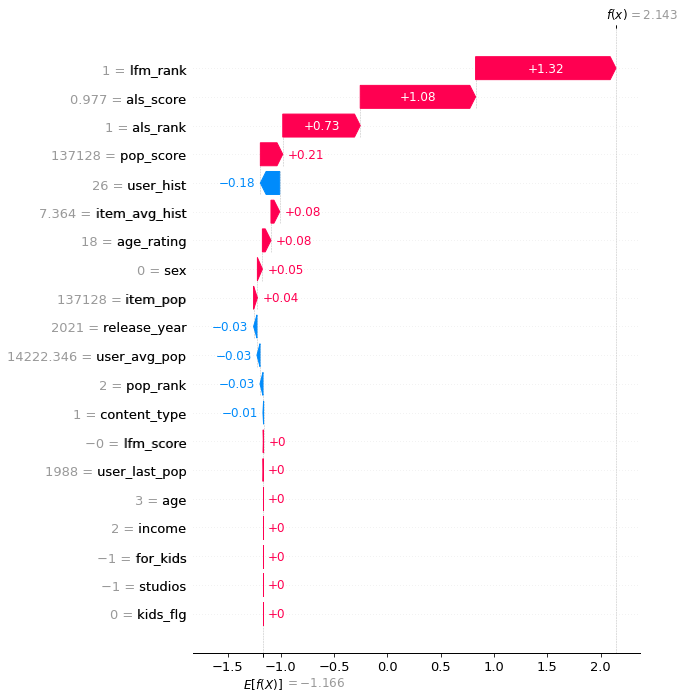

In [52]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap.plots.waterfall(shap_values[0], max_display=len(cols))

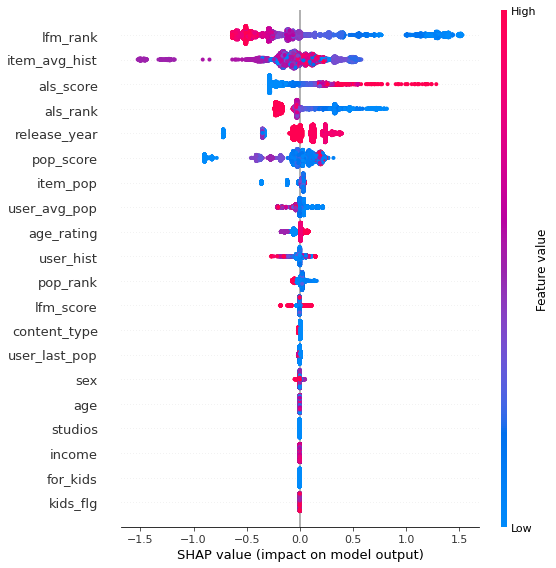

In [53]:
shap.plots.beeswarm(shap_values, max_display=len(cols))

In [54]:
(
    avg_user_metric(
        y_true=np.array(ranker_test['target']), 
        y_pred=np.array(ranker_test['listwise_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score,
    ),
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['listwise_hybrid_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score,
    ),
)

(0.8513336329450247, 0.8513336329450247)

## XGBRanker

In [31]:
# https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRanker

def get_xgb_group(df):
    return np.array(
        df[['user_id', 'item_id']].groupby(by=['user_id']).count()['item_id']
    )

### Optimize hyperparams

In [41]:
def objective_XGBoost_Ranker(trial):
    n_estimators = trial.suggest_int("n_estimators", low=1000, high=10000, step=500)
    max_depth = trial.suggest_int("max_depth", low=3, high=9, step=2)
    learning_rate = trial.suggest_float("learning_rate", low=0.05, high=0.25, step=0.05)
    colsample_bytree = trial.suggest_float("colsample_bytree", low=0.7, high=0.9, step=0.1)

    early_stopping_rounds = 32

    params = {
        'objective': 'rank:ndcg', 
        'n_estimators': n_estimators,  
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'reg_lambda': 1,
        'colsample_bytree': colsample_bytree,
        'random_state': 42,
        'eval_metric': 'ndcg@10'
    }

    fit_params = {
        'X': ranker_train[cols],
        'y': ranker_train['target_ranker'],
        'group': get_xgb_group(ranker_train),
        'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
        'eval_group': [get_xgb_group(ranker_val)],
        'early_stopping_rounds': early_stopping_rounds,
        'verbose': early_stopping_rounds / 4,
    }
    listwise_model = XGBRanker(**params)
    listwise_model.fit(**fit_params)

    y_pred = listwise_model.predict(ranker_test[cols])
    metric_values = calc_metrics_(add_score_and_rank(ranker_test, y_pred, 'listwise'), 'listwise_hybrid_rank')
    return metric_values['map@10'], metric_values['ndcg@10']

In [42]:
%%time

study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(objective_XGBoost_Ranker, n_trials=5)

[I 2022-12-16 18:42:43,661] A new study created in memory with name: no-name-2cd950eb-9063-4a7a-80bd-50b24a306721
[W 2022-12-16 18:42:44,031] Trial 0 failed because of the following error: ValueError('DataFrame.dtypes for data must be int, float, bool or category.  When\ncategorical type is supplied, DMatrix parameter `enable_categorical` must\nbe set to `True`. Invalid columns:age, income')
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_3425/3629488990.py", line 30, in objective_XGBoost_Ranker
    listwise_model.fit(**fit_params)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 1828, in fit
    enable_categorical=self.enable_categorical,
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 410

ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:age, income

## CatBoostRanker

### Optimize hyperparams

In [53]:
def objective_CatBoost_Ranker(trial):
    iterations = trial.suggest_int("iterations", low=100, high=200, step=50)
    depth = trial.suggest_int("depth", low=3, high=5, step=1)
    learning_rate = trial.suggest_float("learning_rate", low=0.1, high=0.3, step=0.1)
    reg_lambda = trial.suggest_float("reg_lambda", low=0.1, high=1, step=0.1)

    early_stopping_rounds = 32

    train_pool = Pool(
        data=ranker_train[cols],
        label=ranker_train['target_ranker'],
        group_id=ranker_train['user_id'].values,
    )
    test_pool = Pool(
        data=ranker_val[cols],
        label=ranker_val['target_ranker'],
        group_id=ranker_val['user_id'].values,
    )

    params = {
        'iterations': iterations,
        'depth': depth,
        'learning_rate': learning_rate,
        'reg_lambda': reg_lambda, 
        'random_seed': 42,
        'early_stopping_rounds': early_stopping_rounds,
        'custom_metric': ['NDCG:top=10'],
        'verbose': 1,
    }

    fit_params = {
        'X': train_pool,
        'eval_set': test_pool,
        'early_stopping_rounds': early_stopping_rounds,
        'plot': 1,
        'cat_features': cat_cols,
        'verbose': early_stopping_rounds / 4,
    }
    listwise_model = CatBoostRanker(**params)
    listwise_model.fit(**fit_params)

    y_pred = listwise_model.predict(ranker_test[cols])
    metric_values = calc_metrics_(add_score_and_rank(ranker_test, y_pred, 'listwise'), 'listwise_hybrid_rank')
    return metric_values['map@10'], metric_values['ndcg@10']

In [54]:
%%time

study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(objective_CatBoost_Ranker, n_trials=5)

[I 2022-12-16 19:50:13,987] A new study created in memory with name: no-name-71f81b85-fdb1-487a-b567-b8a222c4e0d0
[W 2022-12-16 19:50:15,664] Trial 0 failed because of the following error: CatBoostError("features data: pandas.DataFrame column 'age' has dtype 'category' but is not in  cat_features list")
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_3425/1543180470.py", line 17, in objective_CatBoost_Ranker
    group_id=ranker_val['user_id'].values,
  File "/opt/conda/lib/python3.7/site-packages/catboost/core.py", line 793, in __init__
    group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, feature_tags, thread_count)
  File "/opt/conda/lib/python3.7/site-packages/catboost/core.py", line 1420, in _init
    group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, feature_tags, thre

CatBoostError: features data: pandas.DataFrame column 'age' has dtype 'category' but is not in  cat_features list

In [ ]:
trials = study.best_trials
pprint(f"Best trial: {trials}")